# EDA Lab + Homework (Student)

**Goal**: practice high-signal EDA like you would in a FAANG ML interview or on-call investigation.

Rules:
- Work top-to-bottom
- Don't hardcode outputs
- Prefer concise, high-signal plots


In [45]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def check(name: str, cond: bool):
    if not cond:
        raise AssertionError(f"Failed: {name}")
    print(f"OK: {name}")

rng = np.random.default_rng(0)

# Offline dataset (embedded CSV). Synthetic but realistic pitfalls: missingness, heavy tails, leakage-like columns.
CSV = """user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
1,US,basic,400,365,2,8.0,25,0.0,0,0,0
2,US,premium,120,110,18,22.0,41,10.0,0,0,0
3,IN,basic,30,25,1,3.0,19,0.0,1,1,1
4,IN,basic,10,7,0,2.0,22,0.0,1,0,0
5,GB,premium,800,790,30,35.0,52,15.0,0,0,0
6,GB,basic,200,180,5,10.0,33,,1,1,1
7,US,basic,60,55,7,12.0,,0.0,0,0,0
8,CA,premium,90,80,14,18.0,29,5.0,0,0,0
9,CA,basic,15,12,0,1.0,24,0.0,1,1,1
10,IN,premium,300,280,20,25.0,38,20.0,0,0,0
11,US,premium,5,3,0,0.5,27,0.0,1,1,1
12,GB,premium,45,40,9,15.0,31,0.0,0,0,0
13,US,basic,500,490,1,6.0,47,0.0,0,0,0
14,IN,basic,75,70,4,9.0,28,0.0,0,0,0
15,CA,basic,365,360,3,7.0,36,0.0,0,0,0
16,US,premium,20,18,0,1.0,23,0.0,1,1,1
17,GB,basic,150,140,6,11.0,42,0.0,0,0,0
18,IN,premium,220,210,25,28.0,34,25.0,0,0,0
19,US,basic,12,10,0,0.2,21,0.0,1,1,1
20,CA,premium,600,590,22,26.0,55,0.0,0,0,0
"""

df = pd.read_csv(io.StringIO(CSV))
check('n_rows', df.shape[0] == 20)
check('has_target', 'churned' in df.columns)
df


OK: n_rows
OK: has_target


,user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
0,1,US,basic,400,365,2,8.0,25.0,0.0,0,0,0
1,2,US,premium,120,110,18,22.0,41.0,10.0,0,0,0
2,3,IN,basic,30,25,1,3.0,19.0,0.0,1,1,1
3,4,IN,basic,10,7,0,2.0,22.0,0.0,1,0,0
4,5,GB,premium,800,790,30,35.0,52.0,15.0,0,0,0
5,6,GB,basic,200,180,5,10.0,33.0,NaN,1,1,1
6,7,US,basic,60,55,7,12.0,NaN,0.0,0,0,0
7,8,CA,premium,90,80,14,18.0,29.0,5.0,0,0,0
8,9,CA,basic,15,12,0,1.0,24.0,0.0,1,1,1
9,10,IN,premium,300,280,20,25.0,38.0,20.0,0,0,0


## 1) Sanity Checks — 10 minutes


### Task 1.1: Data grain + schema


In [46]:
# TODO: write 1-2 sentences: what is the grain of this dataset?
# 1. the grain of the dataset is the number of rows, unique User_ids.
# 2.

# TODO: inspect dtypes; convert to appropriate types if needed
df.dtypes

# HINT: churned should be int/bool; categorical columns should remain object/category

df['churned'] = df['churned'].astype(bool)
df['refund_after_churn_flag'] = df['refund_after_churn_flag'].astype(bool)
df.dtypes.reset_index().rename(columns={'index': 'column', 0: 'datatype'})



,column,datatype
0,user_id,int64
1,country,object
2,plan,object
3,signup_days_ago,int64
4,tenure_days,int64
5,sessions_last_7d,int64
6,avg_session_min,float64
7,age,float64
8,discount_pct,float64
9,last_payment_failed,int64


### Task 1.2: Missingness + duplicates


In [47]:
# TODO: build a missingness table with columns [n_missing, pct_missing] sorted desc
def missingness_table(df: pd.DataFrame) -> pd.DataFrame:

    missingness_df = df.isnull().sum().reset_index()
    print(missingness_df)
    missingness_df.columns = ['column', 'n_missing']
    missingness_df['pct_missing'] = missingness_df['n_missing'] / len(df)
    return missingness_df.sort_values('pct_missing', ascending=False)


miss = missingness_table(df)
miss

check('miss_has_cols', set(miss.columns) >= {'n_missing','pct_missing'})

# TODO: check duplicate rows and duplicate user_id
n_dup_rows = df.duplicated().sum()
n_dup_user_id = df['user_id'].duplicated().sum()
print(n_dup_rows, n_dup_user_id)
miss


                      index  0
0                   user_id  0
1                   country  0
2                      plan  0
3           signup_days_ago  0
4               tenure_days  0
5          sessions_last_7d  0
6           avg_session_min  0
7                       age  1
8              discount_pct  1
9       last_payment_failed  0
10                  churned  0
11  refund_after_churn_flag  0
OK: miss_has_cols
0 0


,column,n_missing,pct_missing
8,discount_pct,1,0.05
7,age,1,0.05
0,user_id,0,0.00
1,country,0,0.00
3,signup_days_ago,0,0.00
2,plan,0,0.00
5,sessions_last_7d,0,0.00
4,tenure_days,0,0.00
6,avg_session_min,0,0.00
9,last_payment_failed,0,0.00


## 2) Distributions + Outliers — 15 minutes


### Task 2.1: Numeric summaries


In [48]:
# TODO: compute summary stats (mean/median/std/quantiles) for numeric columns
# HINT: Select only Numeric Columns
num = df.select_dtypes(include=np.number)
num.describe(percentiles=[0.05, 0.5, 0.75, 0.90, 0.95, 0.99]).T

,count,mean,std,min,5%,50%,75%,90%,95%,99%,max
user_id,20.0,10.500000,5.916080,1.0,1.950,10.5,15.25,18.1,19.05,19.81,20.0
signup_days_ago,20.0,200.850000,226.280514,5.0,9.750,105.0,316.25,510.0,610.00,762.00,800.0
tenure_days,20.0,191.750000,222.845208,3.0,6.800,95.0,300.00,500.0,600.00,752.00,790.0
sessions_last_7d,20.0,8.350000,9.615092,0.0,0.000,4.5,15.00,22.3,25.25,29.05,30.0
avg_session_min,20.0,11.985000,10.464188,0.2,0.485,9.5,19.00,26.2,28.35,33.67,35.0
age,19.0,33.000000,10.561986,19.0,20.800,31.0,39.50,48.0,52.30,54.46,55.0
discount_pct,19.0,3.947368,7.742191,0.0,0.000,0.0,2.50,16.0,20.50,24.10,25.0
last_payment_failed,20.0,0.350000,0.489360,0.0,0.000,0.0,1.00,1.0,1.00,1.00,1.0


### Task 2.2: Plot 2 high-signal distributions


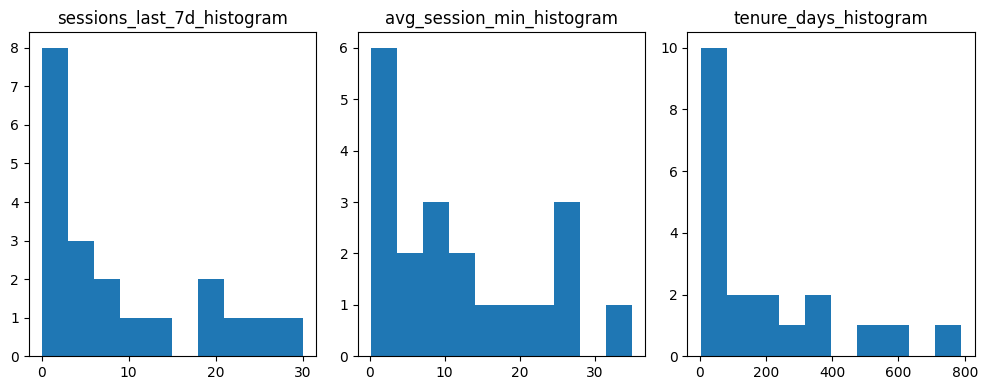

In [49]:
# TODO: pick 2 columns and create 2 plots that reveal something non-trivial
# Example: sessions_last_7d (skew), avg_session_min (heavy tail), tenure_days (range)
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.hist(df['sessions_last_7d'], bins=10)
plt.title('sessions_last_7d_histogram')
# TODO
plt.subplot(1,3,2)
plt.hist(df['avg_session_min'], bins=10)
plt.title('avg_session_min_histogram')

plt.subplot(1,3,3)
plt.hist(df['tenure_days'], bins=10)
plt.title('tenure_days_histogram')
# TODO
plt.tight_layout()
plt.show()


## 3) Target + Slices — 15 minutes


### Task 3.1: Label imbalance


In [50]:
# TODO: compute churn rate and counts
churn_rate = df['churned'].mean()
counts = df['churned'].value_counts()
print(churn_rate)
counts

# Checkpoint: which metric would you choose (accuracy vs F1 vs PR-AUC) and why?
# for such class imbalance problem the metric should be F1  beacuse that's the balance betwwen Precision and Recall.
# PR-AUC can be used where focus is the performance of the minority class as it is truthful view of performance on the minority class.
# Accuracy is misleading because it will high since the model is trained mostly on the majosrity class

0.3


,count
churned,
False,14
True,6


### Task 3.2: Slice analysis


In [51]:
# TODO: compute churn rate by country and by plan
by_country = df.groupby('country')['churned'].mean()
by_plan = df.groupby('plan')['churned'].mean()
by_country
by_plan

# TODO: create a tenure bucket column and compute churn by bucket
# HINT: pd.cut
df2 = df.copy()
df2["tenure_bucket"] = pd.cut(df2["tenure_days"], bins=[0, 14, 30, 60, 90, 180, 10000], labels=["1w", "2w", "1m", "2m", "3m", "6m"])
by_bucket = df2.groupby('tenure_bucket')['churned'].mean()
by_bucket


/tmp/ipython-input-482859100.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_bucket = df2.groupby('tenure_bucket')['churned'].mean()


,churned
tenure_bucket,
1w,0.750000
2w,1.000000
1m,0.000000
2m,0.000000
3m,0.333333
6m,0.000000


## 4) Leakage + Time — 10 minutes


### Task 4.1: Identify leakage-prone features


In [52]:
# TODO: identify columns that likely leak label or post-outcome info.
# HINT: refund_after_churn_flag looks suspicious.
leaky_cols = df['refund_after_churn_flag']
leaky_cols

# TODO: write 2-3 sentences explaining why each is leaky (prediction-time availability).
# 'refund_after_churn_flag' is same 'Churned' column. this will be mis leading to feed into the model.


,refund_after_churn_flag
0,False
1,False
2,True
3,False
4,False
5,True
6,False
7,False
8,True
9,False


## 5) Homework — EDA Write-up


In 10–15 bullets:
- Top 5 data issues/risks
1. Data leaking
2. outlier detection
3. class imbalance for churn
4. data points are not enough to train the model
5. Nulls in the data

- Top 3 features to create next
1. hot encdoing for plan
2. Balancing the target class
3. Bins/range for age of user to check if any particular age group is users are churned.

- What you would do before training any model
1. class balance
2. selecting the right metric for model performance
3. handling nulls
4. choosing the right algorithm
5. choosing the right features to feed into the model

